In [1]:
import pandas as pd
import numpy as np
import itertools as it
import os
import io
import logging

import boto3
import sys
import json
import snowflake.connector

# Reading Data 

In [2]:
input_bucket = "hbo-ingest-datascience-content-dev"

In [3]:
logger = logging.getLogger()
logger.info(f'Loading inputs')
data_list =[]

s3 = boto3.resource('s3')
bucket = s3.Bucket(input_bucket)

for obj in bucket.objects.filter(Prefix='cost_allocation/dev/churn_metric_0906'): #churn_metric_0811
            key = obj.key
            logger.info('Loading csv file {}'.format(key))
            body = obj.get()['Body']
            print('Reading {0} features'.format(key))
            churn_metric = pd.read_csv(body, na_values = [r'\\\\N'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


Reading cost_allocation/dev/churn_metric_0906.csv features


In [4]:
churn_metric.head()

,Unnamed: 0,genre,medal,category,churn_per_hr_person
0,0,action,Platinum,movies,-0.028358
1,1,action,Gold,series,-0.020530
2,2,action,Gold,movies,-0.027117
3,3,action,Silver,series,-0.005406
4,4,action,Silver,movies,-0.019190


In [5]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [6]:
# hours_viewed = run_query('''SELECT * FROM max_dev.workspace.user_title_hours_watched_crossvalidation''')

In [10]:
hours_viewed = pd.read_csv('validation_data.csv')

In [12]:
hours_viewed = hours_viewed[['title_name', 'title_id', 'season_number', 'offering_start_date' , 'ahvr', 'pillar_genre', 'medal', 'content_category', 'asset_run_time_hours']]

In [13]:
hours_viewed.rename(columns = {'ahvr':'average_hours_viewed_60d', 'pillar_genre': 'genre', 'content_category':'category'}, inplace = True)

In [14]:
hours_viewed.category.unique()

array(['movies', 'series', 'special', nan, 'livesports'], dtype=object)

In [15]:
churn_metric.category.unique()

array(['movies', 'series'], dtype=object)

In [16]:
hours_viewed.loc[hours_viewed['genre'] == 'Action/Adventure ', 'genre'] = 'action'
hours_viewed.loc[hours_viewed['genre'] == 'Comedy', 'genre'] = 'comedy'
hours_viewed.loc[hours_viewed['genre'] == 'Drama', 'genre'] = 'drama'
hours_viewed.loc[~hours_viewed['genre'].isin(['action', 'comedy', 'drama']), 'genre'] = 'other'

hours_viewed.loc[hours_viewed['medal'] == 'None', 'medal'] = 'Bronze'

hours_viewed.loc[hours_viewed['category'] == 'special', 'category'] = 'movies'

In [17]:
hours_viewed = hours_viewed.merge(churn_metric[['genre','medal','category', 'churn_per_hr_person']], on = ['genre','medal','category'])

In [18]:
hours_viewed['change_in_churn_60d'] = hours_viewed['average_hours_viewed_60d'] * hours_viewed['churn_per_hr_person']

In [25]:
hours_viewed_thresh = hours_viewed[hours_viewed['average_hours_viewed_60d'] >= 0.001]

In [26]:
churn_metric.head()

,Unnamed: 0,genre,medal,category,churn_per_hr_person
0,0,action,Platinum,movies,-0.028358
1,1,action,Gold,series,-0.020530
2,2,action,Gold,movies,-0.027117
3,3,action,Silver,series,-0.005406
4,4,action,Silver,movies,-0.019190


# Allocate the 60-Day Churn to monthly

In [27]:
ever_green_titles = pd.read_csv('final_evergreen_title_list.csv') #final_evergreen_title_list.csv # ever_green_titles.csv

In [28]:
len(ever_green_titles.title_id.unique())

11

In [29]:
len(hours_viewed_thresh.title_id.unique())

2093

In [30]:
ever_green_titles.sort_values(by = ['title_name']).title_name.unique()

array(['American Pie', 'Annabelle Comes Home', 'Curb Your Enthusiasm',
       'Friends', 'Game of Thrones', 'Pretty Little Liars',
       'Sex and the City', 'The Big Bang Theory', 'The Sopranos',
       'War Dogs', 'X-Men: Dark Phoenix'], dtype=object)

In [31]:
ever_green_title_id = ever_green_titles.title_id.unique()
norm_title_id = hours_viewed_thresh[~hours_viewed_thresh['title_id'].isin(ever_green_title_id)].title_id.unique()

### 1. Normal Titles

In [32]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [33]:
from scipy.optimize import curve_fit

In [34]:
historical_weekly_hours_viewed = pd.read_csv('historical_weekly_hours_viewed.csv')

In [35]:
historical_weekly_hours_viewed.head(10)

,Unnamed: 0,days_on_hbo_max,monthly_average_hours_viewed,monthly_average_hours_viewed_60d,target
0,0,7,0.002413,0.000358,6.749338
1,1,14,0.001161,0.000358,3.245866
2,2,21,0.000903,0.000358,2.525181
3,3,28,0.000758,0.000358,2.120379
4,4,35,0.000619,0.000358,1.730129
5,5,42,0.000499,0.000358,1.395545
6,6,49,0.000437,0.000358,1.222499
7,7,56,0.000395,0.000358,1.105985
8,8,63,0.000358,0.000358,1.000000
9,9,70,0.000313,0.000358,0.876389


In [36]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

## 90% of the retention value deteriorates in the first year
x = historical_weekly_hours_viewed['days_on_hbo_max']
y = historical_weekly_hours_viewed['target']

popt, pcov = curve_fit(func, x, y)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [37]:
func(60, *popt)

0.7287636223051438

In [38]:
popt #0.00059137, 0.03019112, 0.00055421

array([9.10159297, 0.0671376 , 0.56670655])

In [39]:
x1 = pd.Series(np.arange(0,365,1))
y1 = func(x1, *popt)

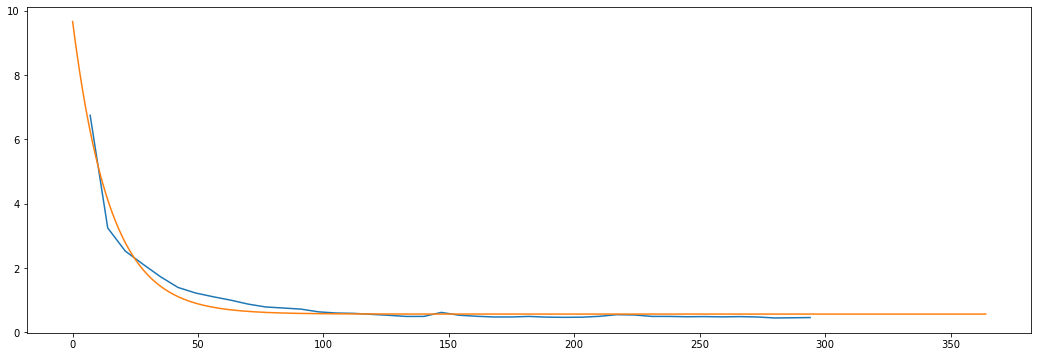

In [40]:
fig, ax = plt.subplots(figsize=(18, 6))
plt.plot(x, y)
plt.plot(x1, y1)
plt.show()

In [70]:
dt_df = pd.DataFrame()
dt_df['days_on_hbo_max'] = [i for i in range(0, 365*3, 1)]
dt_df['factor'] = func(dt_df['days_on_hbo_max'], *popt)
dt_df['key'] = 1

In [71]:
day_60_cum_sum = dt_df[dt_df['days_on_hbo_max']<60].factor.sum()

In [72]:
hours_viewed_decay_norm = hours_viewed_thresh[hours_viewed_thresh['title_id'].isin(norm_title_id)].copy()
hours_viewed_decay_norm['key'] = 1

hours_viewed_decay_norm = hours_viewed_decay_norm.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

hours_viewed_decay_norm['change_in_churn'] = hours_viewed_decay_norm['change_in_churn_60d']/day_60_cum_sum*hours_viewed_decay_norm['factor']*hours_viewed_decay_norm['asset_run_time_hours']

hours_viewed_decay_norm['request_date'] = pd.to_datetime(hours_viewed_decay_norm['offering_start_date']) \
                                        + pd.to_timedelta(hours_viewed_decay_norm['days_on_hbo_max'], unit='D')

hours_viewed_decay_norm = hours_viewed_decay_norm[hours_viewed_decay_norm['request_date'] <= '2023-03-01']

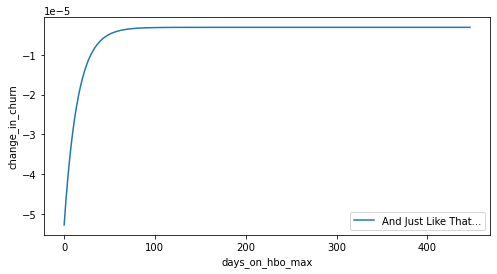

In [73]:
fig, ax = plt.subplots(figsize=(8, 4))
test = hours_viewed_decay_norm[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max','change_in_churn']]
plot_df = test[test['title_name'] == 'And Just Like That...']
plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label='And Just Like That...')

ax.set_xlabel('days_on_hbo_max')
ax.set_ylabel('change_in_churn')
ax.legend()

plt.show()

### 2. Evergreen Titles

#### 2.1 Sogmoid Decay

In [45]:
# ## 90% of the retention value is deteriorated in the first year
# x = [0, 0.25, 1.5, 3]
# y = [1, 0.99, 0.5, 0.001]

# def sigmoid(x, L ,x0, k, b):
#     y = L / (1 + np.exp(-k*(x-x0))) + b
#     return (y)

# p0 = [max(y), np.median(x),1,min(y)] # this is an mandatory initial guess

# popt, pcov = curve_fit(sigmoid, x, y ,p0, method='dogbox')

# x1 = pd.Series(np.arange(0,5,0.1))
# y1 = sigmoid(x1, *popt)

# fig, ax = plt.subplots(figsize=(18, 6))
# plt.plot(x1, y1)
# plt.show()

In [46]:
# dt_df = pd.DataFrame()
# dt_df['days_on_hbo_max'] = [i for i in range(0, 365*3, 1)]
# dt_df['factor'] = sigmoid(dt_df['days_on_hbo_max']/365, *popt)
# dt_df['key'] = 1

# hours_viewed_decay_evergreen = hours_viewed_thresh[hours_viewed_thresh['title_id'].isin(ever_green_title_id)]

# hours_viewed_decay_evergreen = hours_viewed_decay_evergreen.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

# hours_viewed_decay_evergreen['change_in_churn'] = hours_viewed_decay_evergreen['change_in_churn_60d']/60*hours_viewed_decay_evergreen['factor']

# hours_viewed_decay_evergreen['days_on_hbo_max'] = hours_viewed_decay_evergreen['days_on_hbo_max']+60

# hours_viewed_decay_evergreen['request_date'] = pd.to_datetime(hours_viewed_decay_evergreen['offering_start_date']) \
#                                         + pd.to_timedelta(hours_viewed_decay_evergreen['days_on_hbo_max'], unit='D')

# hours_viewed_decay_evergreen = hours_viewed_decay_evergreen[hours_viewed_decay_evergreen['request_date'] <= '2023-03-01']


In [47]:
# fig, ax = plt.subplots(figsize=(8, 4))
# test = pd.concat([hours_viewed_60d[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']],
#                 hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']]],
#                 axis = 0)


# for i in range(1, 11, 1):
#     plot_df = test[(test['title_name'] == 'Friends') &(test['season_number'] == i)]
#     plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label= 'Friends S' + str(i))

# ax.set_xlabel('days_on_hbo_max')
# ax.set_ylabel('change_in_churn')
# ax.legend()

# plt.show()

#### 2.2 Keep the retention value all the way along

In [48]:
dt_df.head()

,days_on_hbo_max,factor,key
0,0,9.668300,1
1,1,9.077301,1
2,2,8.524679,1
3,3,8.007940,1
4,4,7.524755,1


In [61]:
dt_df = pd.DataFrame()
dt_df['days_on_hbo_max'] = [i for i in range(0, 365*3, 1)]
dt_df['key'] = 1

hours_viewed_decay_evergreen = hours_viewed_thresh[hours_viewed_thresh['title_id'].isin(ever_green_title_id)]
hours_viewed_decay_evergreen['key'] = 1

hours_viewed_decay_evergreen = hours_viewed_decay_evergreen.merge(dt_df, on = ['key']).drop(['key'], axis = 1)

hours_viewed_decay_evergreen['change_in_churn'] = hours_viewed_decay_evergreen['change_in_churn_60d']/60*hours_viewed_decay_evergreen['asset_run_time_hours']

hours_viewed_decay_evergreen['request_date'] = pd.to_datetime(hours_viewed_decay_evergreen['offering_start_date']) \
                                        + pd.to_timedelta(hours_viewed_decay_evergreen['days_on_hbo_max'], unit='D')

hours_viewed_decay_evergreen = hours_viewed_decay_evergreen[hours_viewed_decay_evergreen['request_date'] <= '2023-03-01']


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


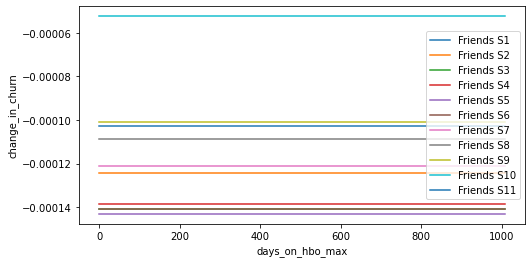

In [63]:
fig, ax = plt.subplots(figsize=(8, 4))
test = hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'request_date', 'days_on_hbo_max', 'change_in_churn']]


for i in range(1, 12, 1):
    plot_df = test[(test['title_name'] == 'Friends') &(test['season_number'] == i)]
    plt.plot(plot_df['days_on_hbo_max'], plot_df['change_in_churn'], label= 'Friends S' + str(i))

ax.set_xlabel('days_on_hbo_max')
ax.set_ylabel('change_in_churn')
ax.legend()

plt.show()

## UNION ALL THE DFs

In [74]:
data = pd.concat([hours_viewed_decay_norm[['title_name', 'title_id', 'season_number', 'genre', 'medal', 'offering_start_date', 'request_date',  'days_on_hbo_max', 'change_in_churn']],
                hours_viewed_decay_evergreen[['title_name', 'title_id', 'season_number', 'genre', 'medal', 'offering_start_date', 'request_date',  'days_on_hbo_max', 'change_in_churn']] ],
                axis = 0)

In [75]:
data = data.merge(hours_viewed_thresh[['title_id', 'season_number', 'average_hours_viewed_60d', 'churn_per_hr_person', 'change_in_churn_60d', 'asset_run_time_hours']],
                 on = ['title_id', 'season_number'])

In [76]:
data['date_month'] = data['request_date'].dt.to_period('M')

In [77]:
# data.groupby(['date_month']).change_in_churn.sum().reset_index().sort_values(by = ['date_month'])

In [78]:
data[data['title_id'] == 'GX9KHPw1OIMPCJgEAAAAD']

,title_name,title_id,season_number,genre,medal,offering_start_date,request_date,days_on_hbo_max,change_in_churn,average_hours_viewed_60d,churn_per_hr_person,change_in_churn_60d,asset_run_time_hours,date_month
1824265,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,action,Platinum,2020-12-25,2020-12-25,0,-0.001897,0.481389,-0.028358,-0.013651,2.466944,2020-12
1824266,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,action,Platinum,2020-12-25,2020-12-26,1,-0.001781,0.481389,-0.028358,-0.013651,2.466944,2020-12
1824267,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,action,Platinum,2020-12-25,2020-12-27,2,-0.001672,0.481389,-0.028358,-0.013651,2.466944,2020-12
1824268,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,action,Platinum,2020-12-25,2020-12-28,3,-0.001571,0.481389,-0.028358,-0.013651,2.466944,2020-12
1824269,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,action,Platinum,2020-12-25,2020-12-29,4,-0.001476,0.481389,-0.028358,-0.013651,2.466944,2020-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825057,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,action,Platinum,2020-12-25,2023-02-25,792,-0.000111,0.481389,-0.028358,-0.013651,2.466944,2023-02
1825058,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,action,Platinum,2020-12-25,2023-02-26,793,-0.000111,0.481389,-0.028358,-0.013651,2.466944,2023-02
1825059,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,action,Platinum,2020-12-25,2023-02-27,794,-0.000111,0.481389,-0.028358,-0.013651,2.466944,2023-02
1825060,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,action,Platinum,2020-12-25,2023-02-28,795,-0.000111,0.481389,-0.028358,-0.013651,2.466944,2023-02


In [79]:
data[data['date_month'] == '2022-09'].groupby(['title_name', 'title_id', 'season_number']).sum().reset_index()\
.sort_values(by = ['change_in_churn']).head(20)

,title_name,title_id,season_number,days_on_hbo_max,change_in_churn,average_hours_viewed_60d,churn_per_hr_person,change_in_churn_60d,asset_run_time_hours
870,House of the Dragon,GYsYeoAxKH8LCwgEAAAOR,1,735,-0.014530,5.028373,-0.550390,-0.092252,307.77486
696,Friends,GXdbR_gOXWJuAuwEAACVH,5,25245,-0.004294,1.868226,-0.477415,-0.029731,259.99125
694,Friends,GXdbR_gOXWJuAuwEAACVH,3,25245,-0.004228,1.719096,-0.477415,-0.027357,278.18289
697,Friends,GXdbR_gOXWJuAuwEAACVH,6,25245,-0.004222,1.776719,-0.477415,-0.028274,268.74975
695,Friends,GXdbR_gOXWJuAuwEAACVH,4,25245,-0.004163,1.801594,-0.477415,-0.028670,261.36639
1755,The Big Bang Theory,GXdRsewUPO5uAuwEAABEI,4,25245,-0.003757,1.746860,-0.477415,-0.027799,243.26634
693,Friends,GXdbR_gOXWJuAuwEAACVH,2,25245,-0.003732,1.582261,-0.477415,-0.025180,266.76627
1756,The Big Bang Theory,GXdRsewUPO5uAuwEAABEI,5,25245,-0.003727,1.739878,-0.477415,-0.027688,242.29968
698,Friends,GXdbR_gOXWJuAuwEAACVH,7,25245,-0.003629,1.594585,-0.477415,-0.025376,257.39145
1757,The Big Bang Theory,GXdRsewUPO5uAuwEAABEI,6,25245,-0.003605,1.695214,-0.477415,-0.026977,240.51633


In [80]:
# data[(data['request_date'] == '2023-03-01')
#     &(data['title_name'] == 'Friends')].sort_values(by = ['change_in_churn']).head(20)

# Correlation with Change in Churn

## 1. Correlation with Churn itself

In [81]:
churn_genpop = run_query('''
select
     dt.start_date as date_month,
    COUNT(DISTINCT CASE WHEN is_cancel = TRUE THEN up.hbo_uuid ELSE NULL END) as churns,
    COUNT(DISTINCT up.hbo_uuid) as total_subs,
    churns/total_subs as churn_rate
from MAX_PROD.CONTENT_ANALYTICS.CALENDAR_DATE_TRACKER dt
JOIN max_prod.identity.user_profile_dim_current up 
JOIN max_dev.workspace.user_retain_churn_list_test as c 
    on c.hurley_user_id = up.hurley_user_id
    and c.cycle_expire_date BETWEEN START_DATE and END_DATE
WHERE 1=1
AND up.is_primary_profile=1
AND dt.end_date = DATEADD('DAY', -1, (DATEADD('MONTH', 1, dt.start_date)))
AND dt.start_date = DATE_TRUNC('MONTH', dt.start_date)
and dt.start_date < '2023-03-01'
and SUB_MONTH <=24
and SUB_MONTH >1
group by 1
order by 1
''')

In [82]:
churn_genpop_tenure = run_query('''
select
     dt.start_date as date_month, sub_month as tenure,
    COUNT(DISTINCT CASE WHEN is_cancel = TRUE THEN up.hbo_uuid ELSE NULL END) as churns,
    COUNT(DISTINCT up.hbo_uuid) as total_subs,
    churns/total_subs as churn_rate
from MAX_PROD.CONTENT_ANALYTICS.CALENDAR_DATE_TRACKER dt
JOIN max_prod.identity.user_profile_dim_current up 
JOIN max_dev.workspace.user_retain_churn_list_test as c 
    on c.hurley_user_id = up.hurley_user_id
    and c.cycle_expire_date BETWEEN START_DATE and END_DATE
WHERE 1=1
AND up.is_primary_profile=1
AND dt.end_date = DATEADD('DAY', -1, (DATEADD('MONTH', 1, dt.start_date)))
AND dt.start_date = DATE_TRUNC('MONTH', dt.start_date)
and dt.start_date < '2023-03-01'
and SUB_MONTH <=24
group by 1, 2
order by 1, 2
''')

In [83]:
churn_exclude_t1 = run_query('''
select
     dt.start_date as date_month,
    COUNT(DISTINCT CASE WHEN is_cancel = TRUE THEN up.hbo_uuid ELSE NULL END) as churns,
    COUNT(DISTINCT up.hbo_uuid) as total_subs,
    churns/total_subs as churn_rate
from MAX_PROD.CONTENT_ANALYTICS.CALENDAR_DATE_TRACKER dt
JOIN max_prod.identity.user_profile_dim_current up 
JOIN max_dev.workspace.user_retain_churn_list_test as c 
    on c.hurley_user_id = up.hurley_user_id
    and c.cycle_expire_date BETWEEN START_DATE and END_DATE
WHERE 1=1
AND up.is_primary_profile=1
AND dt.end_date = DATEADD('DAY', -1, (DATEADD('MONTH', 1, dt.start_date)))
AND dt.start_date = DATE_TRUNC('MONTH', dt.start_date)
and dt.start_date < '2023-03-01'
AND SUB_MONTH > 1
group by 1
order by 1
''')

In [84]:
churn_genpop.head()

,date_month,churns,total_subs,churn_rate
0,2020-06-01,9,84,0.107143
1,2020-07-01,2125,31493,0.067475
2,2020-08-01,77090,794407,0.097041
3,2020-09-01,92234,1014273,0.090936
4,2020-10-01,107861,1230141,0.087682


In [87]:
aggregated_churn = data.groupby(['date_month'])['change_in_churn'].sum().reset_index()
aggregated_churn['date_month'] = aggregated_churn['date_month'].dt.to_timestamp().dt.strftime('%Y-%m-%d')

#### GENPOP ONLY LOOKS AT 2022-01-01 ON-WARDS ###################################
aggregated_churn = aggregated_churn[aggregated_churn['date_month']>='2022-01-01']

#### Shift one month forward
# aggregated_churn['date_month']  = (pd.to_datetime(aggregated_churn['date_month']) + pd.DateOffset(months=1)).dt.strftime('%Y-%m-%d')

In [88]:
churn_genpop_tenure_pivot = pd.pivot_table(churn_genpop_tenure, values='churn_rate', index=['date_month'],
                       columns=['tenure'], fill_value=0, aggfunc='first').reset_index()

In [89]:
churn_all = churn_genpop_tenure_pivot.merge(churn_genpop[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'genpop_churn'}),
                                           on = ['date_month'])\
                                    .merge(churn_exclude_t1[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'churn_exclude_t1'}),
                                          on = ['date_month'])

In [90]:
churn_all['date_month'] = churn_all['date_month'].astype(str)

In [91]:
churn_all.head()

,date_month,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,genpop_churn,churn_exclude_t1
0,2020-06-01,0.081925,0.416667,0.059701,0.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.107143,0.107143
1,2020-07-01,0.147216,0.067450,0.125000,0.030769,0.000000,0.000000,0,0,0.500000,...,0,0,0,0,0.000000,0,0,0,0.067475,0.067473
2,2020-08-01,0.246896,0.098401,0.061422,0.068966,0.046875,0.000000,0.000000,0,0.000000,...,0.000000,0,0,0,0,0.000000,0,0,0.097041,0.097041
3,2020-09-01,0.266349,0.131667,0.073671,0.047285,0.640000,0.949153,0.000000,0.000000,0,...,0.000000,0.000000,0,0,0,0,0.000000,0,0.090936,0.090936
4,2020-10-01,0.232411,0.143210,0.101009,0.059563,0.040794,0.090909,0.000000,0.000000,0.000000,...,0.000000,0.500000,0.000000,0,0,0,0,0.000000,0.087682,0.087682


In [92]:
churn_all = churn_all.merge(aggregated_churn, on = ['date_month'])

In [93]:
TARGET_COL = ['change_in_churn']
FEATURE_COLS = [i for i in range(1, 25)]+['genpop_churn', 'churn_exclude_t1']

In [94]:
for i in FEATURE_COLS:
    churn_all[i] = churn_all[i].astype(float)

In [95]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [96]:
plot_data=churn_all[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
# corr.sort_values(by = TARGET_COL)
# 0.819
corr

,change_in_churn
1,-0.070432
2,0.248547
3,0.367976
4,0.709410
5,0.128793
6,-0.178719
7,0.007835
8,0.030798
9,-0.162418
10,-0.054815


<AxesSubplot:>

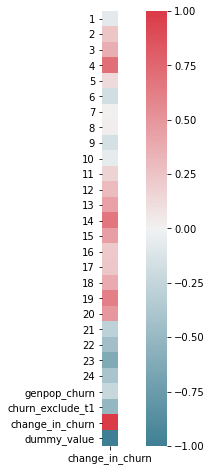

In [97]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

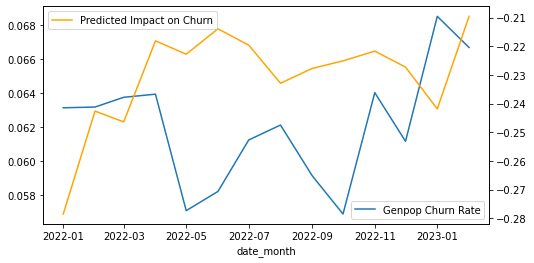

In [98]:
fig, ax = plt.subplots(figsize=(8, 4))

plot_df = churn_all
plot_df['date_month'] = pd.to_datetime(plot_df['date_month'])
ax.plot(plot_df['date_month'], plot_df['genpop_churn'], label= 'Genpop Churn Rate')

ax2 = ax.twinx()
ax2.plot(plot_df['date_month'], plot_df['change_in_churn'], label= 'Predicted Impact on Churn', color = 'orange')

ax.set_xlabel('date_month')
ax.legend(loc = 'lower right')
ax2.legend(loc = 'upper left')

plt.show()

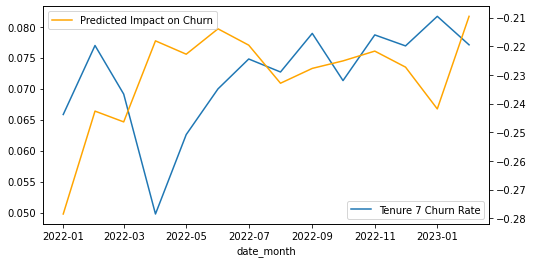

In [99]:
fig, ax = plt.subplots(figsize=(8, 4))

plot_df = churn_all
plot_df['date_month'] = pd.to_datetime(plot_df['date_month'])
ax.plot(plot_df['date_month'], plot_df[7], label= 'Tenure 7 Churn Rate')

ax2 = ax.twinx()
ax2.plot(plot_df['date_month'], plot_df['change_in_churn'], label= 'Predicted Impact on Churn', color = 'orange')

ax.set_xlabel('date_month')
ax.legend(loc = 'lower right')
ax2.legend(loc = 'upper left')

plt.show()

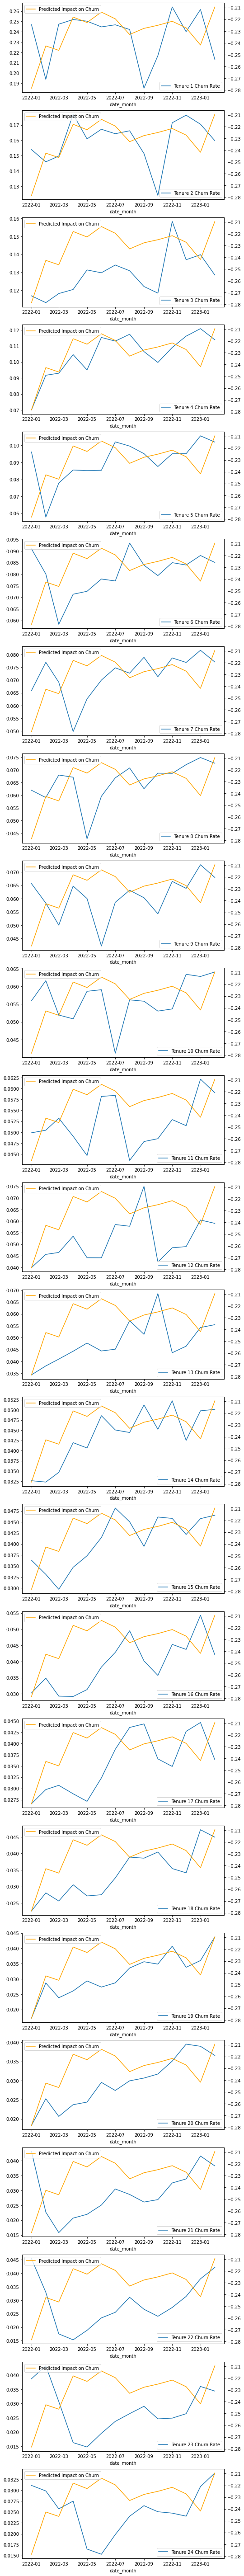

In [100]:
# fig, ax = plt.subplots(figsize=(8, 4))
plot_df = churn_all
plot_df['date_month'] = pd.to_datetime(plot_df['date_month'])
fig, ax = plt.subplots(24,1,figsize=(8, 104))

for i in range(0, 24, 1):
    ax1 = ax[i]
    ax1.plot(plot_df['date_month'], plot_df[i+1], label= 'Tenure ' + str(i+1)+ ' Churn Rate')

    ax2 = ax[i].twinx()
    ax2.plot(plot_df['date_month'], plot_df['change_in_churn'], label= 'Predicted Impact on Churn', color = 'orange')

    ax1.set_xlabel('date_month')
    ax1.legend(loc = 'lower right')
    ax2.legend(loc = 'upper left')

plt.show()
    

## 2. Correlation with Tenure Buckets

In [ ]:
churn_genpop_tenure_bucekts = run_query('''
select
     dt.start_date as date_month, 
     case when sub_month <=3 then '1-3'
          when sub_month <=6 then '4-6'
          when sub_month <=12 then '7-12'
          when sub_month <=24 then '13-24'
          else '24+'
     end as tenure,
    COUNT(DISTINCT CASE WHEN is_cancel = TRUE THEN up.hbo_uuid ELSE NULL END) as churns,
    COUNT(DISTINCT up.hbo_uuid) as total_subs,
    churns/total_subs as churn_rate
from MAX_PROD.CONTENT_ANALYTICS.CALENDAR_DATE_TRACKER dt
JOIN max_prod.identity.user_profile_dim_current up 
JOIN max_dev.workspace.user_retain_churn_list_test as c 
    on c.hurley_user_id = up.hurley_user_id
    and c.cycle_expire_date BETWEEN START_DATE and END_DATE
WHERE 1=1
AND up.is_primary_profile=1
AND dt.end_date = DATEADD('DAY', -1, (DATEADD('MONTH', 1, dt.start_date)))
AND dt.start_date = DATE_TRUNC('MONTH', dt.start_date)
and dt.start_date < '2023-03-01'
--and SUB_MONTH <=24
group by 1, 2
order by 1, 2
''')

In [ ]:
churn_genpop_tenure_bucekts_pivot = pd.pivot_table(churn_genpop_tenure_bucekts, values='churn_rate', index=['date_month'],
                       columns=['tenure'], fill_value=0, aggfunc='first').reset_index()

In [ ]:
aggregated_churn = data.groupby(['date_month'])['change_in_churn'].sum().reset_index()
aggregated_churn['date_month'] = aggregated_churn['date_month'].dt.to_timestamp().dt.strftime('%Y-%m-%d')

### GENPOP ONLY LOOKS AT 2022-01-01 ON-WARDS ###################################
aggregated_churn = aggregated_churn[aggregated_churn['date_month']>='2022-01-01']

In [ ]:
churn_bucekts_all = churn_genpop_tenure_bucekts_pivot.merge(churn_genpop[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'genpop_churn'}),
                                           on = ['date_month'])\
                                    .merge(churn_exclude_t1[['date_month', 'churn_rate']].rename(columns = {'churn_rate':'churn_exclude_t1'}),
                                          on = ['date_month'])

In [ ]:
churn_bucekts_all['date_month'] = churn_bucekts_all['date_month'].astype(str)

In [ ]:
churn_bucekts_all = churn_bucekts_all.merge(aggregated_churn, on = ['date_month'])

In [ ]:
churn_bucekts_all.head()

In [ ]:
TARGET_COL = ['change_in_churn']
FEATURE_COLS = ['1-3', '4-6', '7-12', '13-24','24+', 'genpop_churn']

In [ ]:
FEATURE_COLS

In [ ]:
for i in FEATURE_COLS:
    churn_bucekts_all[i] = churn_bucekts_all[i].astype(float)

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [ ]:
plot_data=churn_bucekts_all[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
# corr.sort_values(by = TARGET_COL)
# 0.819
corr

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

# Write to S3/SF

In [105]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [125]:
import boto3
import io

def to_s3(filename, output_bucket, content):
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)
    
output_bucket = 'hbo-outbound-datascience-content-dev'
s3 = boto3.resource('s3')
bucket = s3.Bucket(output_bucket)

def write_to_sf(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'title_hours_viewed_retention/{}.csv'.format(file_name)
    to_s3(filename, output_bucket, content)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [87]:
data.head()

,title_name,title_id,season_number,genre,medal,offering_start_date,request_date,days_on_hbo_max,change_in_churn,average_hours_viewed_60d,churn_per_hr_person,change_in_churn_60d,asset_run_time_hours,date_month
0,Jeepers Creepers,GV7tyFwyT5IORngEAAAAy,0,other,Bronze,2020-07-01,2020-07-01,0,-0.000023,0.041448,-0.033936,-0.001407,1.516111,2020-07
1,Jeepers Creepers,GV7tyFwyT5IORngEAAAAy,0,other,Bronze,2020-07-01,2020-07-02,1,-0.000023,0.041448,-0.033936,-0.001407,1.516111,2020-07
2,Jeepers Creepers,GV7tyFwyT5IORngEAAAAy,0,other,Bronze,2020-07-01,2020-07-03,2,-0.000023,0.041448,-0.033936,-0.001407,1.516111,2020-07
3,Jeepers Creepers,GV7tyFwyT5IORngEAAAAy,0,other,Bronze,2020-07-01,2020-07-04,3,-0.000023,0.041448,-0.033936,-0.001407,1.516111,2020-07
4,Jeepers Creepers,GV7tyFwyT5IORngEAAAAy,0,other,Bronze,2020-07-01,2020-07-05,4,-0.000023,0.041448,-0.033936,-0.001407,1.516111,2020-07


In [88]:
# data.to_csv('daily_monthly_retention_value.csv')

In [122]:
'daily_monthly_retention_value_'+pd.Timestamp.today().strftime('%Y-%m-%d') 

'daily_monthly_retention_value_2023-09-14'

In [123]:
filename = 'daily_monthly_retention_value_'+pd.Timestamp.today().strftime('%Y-%m-%d')
write_to_sf(data,  filename)

In [126]:
output_bucket+'/title_hours_viewed_retention/{}.csv'.format(filename)

'hbo-outbound-datascience-content-dev/title_hours_viewed_retention/daily_monthly_retention_value_2023-09-14.csv'

In [56]:
data[data['date_month'] == '2022-12'].groupby(['title_name', 'title_id', 'season_number']).sum().reset_index()\
.sort_values(by = ['change_in_churn']).head(20)

,title_name,title_id,season_number,days_on_hbo_max,change_in_churn
502,Euphoria,GXKN_xQX5csPDwwEAAABj,2,10540,-0.008531
742,House of the Dragon,GYsYeoAxKH8LCwgEAAAOR,1,3596,-0.003057
785,Injustice,GYbvoqgoeYawYwwEAAAAN,0,10323,-0.002646
856,Kong: Skull Island,GX-nzMwc-EaCFpgEAAAMh,0,22134,-0.002619
694,Harry Potter 20th Anniversary: Return to Hogwarts,GYbzrRAvf-ZPCKQEAAAAX,0,10819,-0.002506
1515,The Batman,GYiDbSAmIpMNvYAEAAAAI,0,7502,-0.002218
570,Free Guy,GYdYmPQZFO7eZGAEAAAAT,0,9176,-0.002047
1671,The King's Man,GYeGXugg4ewPCwgEAABi1,0,9331,-0.001959
579,Friends,GXdbR_gOXWJuAuwEAACVH,5,28923,-0.001759
578,Friends,GXdbR_gOXWJuAuwEAACVH,4,28923,-0.001702
